https://towardsdatascience.com/detecting-fake-news-with-and-without-code-dd330ed449d9

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns

Load the data

In [3]:
fake = pd.read_csv('kaggle_datasets/fake_news_dataset/Fake.csv')
true = pd.read_csv('kaggle_datasets/fake_news_dataset/True.csv')

Set the flags to track fake/true

In [4]:
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
true.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",true
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",true


Merge the data

In [7]:
data = pd.concat([fake, true]).reset_index(drop = True)

Shuffle the data to avoid bias

In [ ]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

Remove un-necessary columns

In [9]:
data.drop(["date"], axis=1, inplace=True)
data.drop(['title'], axis=1, inplace=True)

Make all lowercase

In [10]:
data['text'] = data['text'].apply(lambda x: x.lower())

Remove all punctuation marks

In [12]:
import string
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
data['text'] = data['text'].apply(punctuation_removal)

Remove stopwords

In [15]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /home/anurag/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data exploration

In [16]:
print(data.groupby(['subject'])['text'].count())

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


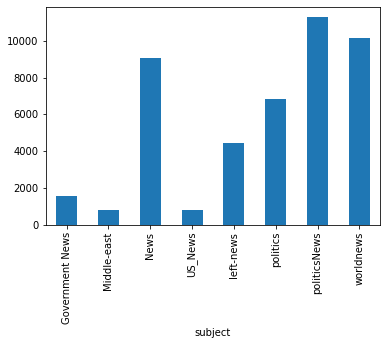

In [19]:
from matplotlib import pyplot as plt
data.groupby(['subject'])['text'].count().plot(kind='bar')
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


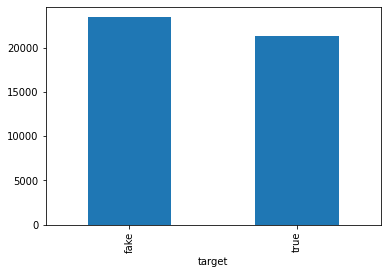

In [21]:
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

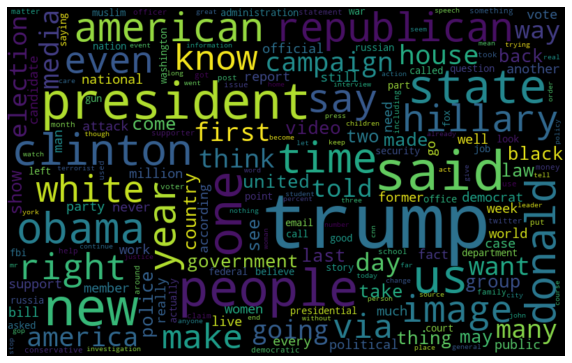

In [22]:
from wordcloud import WordCloud
fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

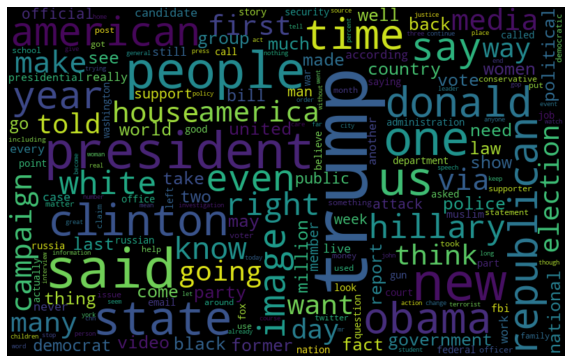

In [24]:
from wordcloud import WordCloud
real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, 
                      height= 500,
                      max_font_size = 110,
                      collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
from nltk import tokenize
token_space = tokenize.WhitespaceTokenizer()
def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

Most frequent words in fake news

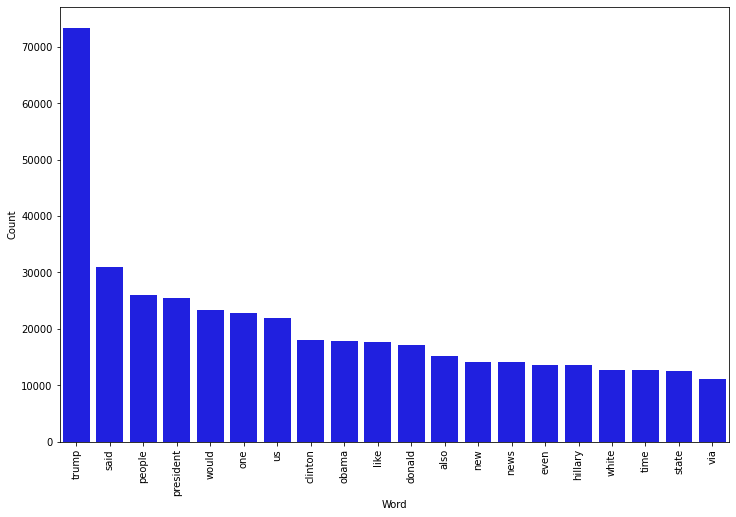

In [28]:
counter(data[data['target'] == 'fake'], 'text', 20)

Most fake words in real news

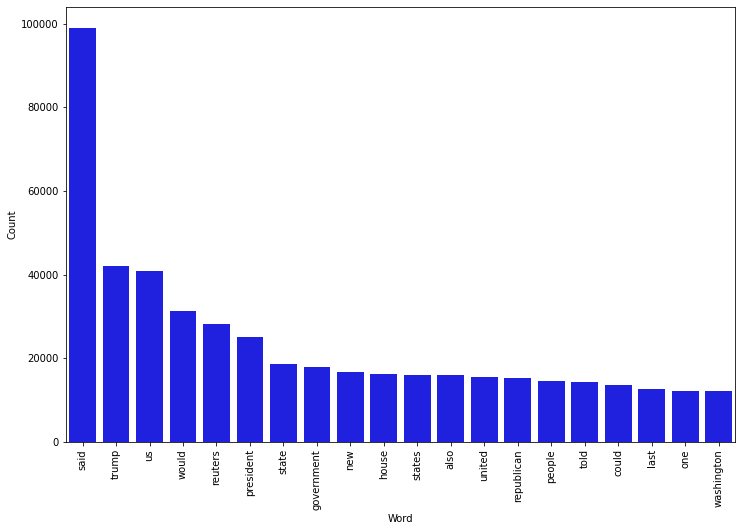

In [29]:
counter(data[data['target'] == 'true'], 'text', 20)

Modeling

In [32]:
from sklearn import metrics
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

Do Logistic Regression on the data

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
pipe = Pipeline([('vect', CountVectorizer()),
                ('tdidf', TfidfTransformer()),
                ('model', LogisticRegression())])

model = pipe.fit(X_train, y_train)

prediction = model.predict(X_test)
print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100, 2)))

Accuracy: 98.85%


Confusion matrix, without normalization


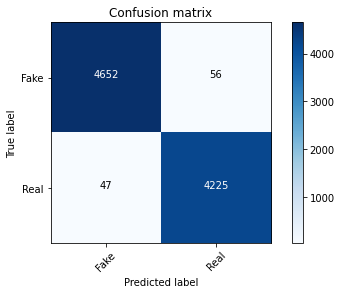

In [42]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Do Decision Tree Classifier

In [43]:
from sklearn.tree import DecisionTreeClassifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                ('model', DecisionTreeClassifier(criterion='entropy',
                                                max_depth=20,
                                                splitter='best',
                                                random_state=42))])

model = pipe.fit(X_train, y_train)

pred = model.predict(X_test)
print("Accuracy :{}%".format(round(accuracy_score(y_test, pred) * 100, 2)))

Accuracy :99.6%


Confusion matrix, without normalization


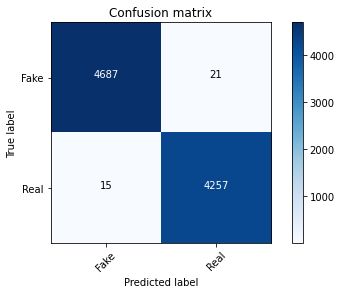

In [44]:
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Random forest Classifer

In [45]:
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.1%


Confusion matrix, without normalization


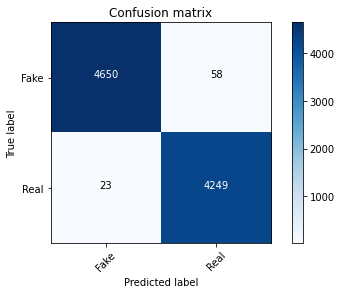

In [46]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])